In [0]:
# use kaggle data to train models
# then will test on my scraped dataset

#### Objective: 
I plan to use the Word2Vec algorithm to train a new set of embeddings representative of the wine domain, then use those embeddings to fit a LTSM classification model. I also will plan on implementing a more simple, baseline model such as an SVM. 

#### Prep

In [0]:
# set working directory
import os
import sys
project_root = '/Users/kgedney/Documents/georgetown/anly580/anly580-wine-project'
os.chdir(project_root)

In [0]:
# install packages
import numpy as np
import pandas as pd


from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [0]:
# kaggle load data 
# ref: https://www.kaggle.com/zynicide/wine-reviews#winemag-data_first150k.csv
df_full = pd.read_csv('data/winemag-data_first150k.csv', encoding='utf8')

In [0]:
df_full.columns

Index(['Unnamed: 0', 'country', 'description', 'designation', 'points',
       'price', 'province', 'region_1', 'region_2', 'variety', 'winery'],
      dtype='object')

#### Google Colab Prep

In [0]:
# install packages
import numpy as np
import pandas as pd


from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [1]:
# get data from Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [7]:
# manually add file from local to drive
df_full = pd.read_csv('winemag-data_first150k.csv', encoding='utf8')
df_full.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


#### Define Classes

In [8]:
# select wines with over 1050 tasting notes (to make an even 30 varities)
variety_counts = pd.DataFrame(df_full['variety'].value_counts())
varieties      = list(variety_counts.index[variety_counts['variety'] > 1050])
len(varieties)

30

In [0]:
df = df_full[df_full['variety'].isin(varieties)]

In [10]:
df.variety.value_counts()

Chardonnay                       14482
Pinot Noir                       14291
Cabernet Sauvignon               12800
Red Blend                        10062
Bordeaux-style Red Blend          7347
Sauvignon Blanc                   6320
Syrah                             5825
Riesling                          5524
Merlot                            5070
Zinfandel                         3799
Sangiovese                        3345
Malbec                            3208
White Blend                       2824
Rosé                              2817
Tempranillo                       2556
Nebbiolo                          2241
Portuguese Red                    2216
Sparkling Blend                   2004
Shiraz                            1970
Corvina, Rondinella, Molinara     1682
Rhône-style Red Blend             1505
Barbera                           1365
Pinot Gris                        1365
Cabernet Franc                    1363
Sangiovese Grosso                 1346
Pinot Grigio             

In [11]:
# map classes to integers
df['variety_code'] = pd.Categorical(df.variety).codes

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [0]:
# set classes
x = df.description.values
y = df.variety_code.values

In [0]:
# split test and train
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=522)

#### Baseline: Linear SVM

In [0]:
# majority class prediction
np.mean(y_test == 6)

0.11562917662306103

In [0]:
# data preprocess
tfidf_vec   = TfidfVectorizer()
x_train_vec = tfidf_vec.fit_transform(x_train)
x_test_vec  = tfidf_vec.transform(x_test)
x_train_vec.shape

/Users/kgedney/anaconda/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:1059: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


(98761, 26413)

In [0]:
# fit model
from sklearn.svm import LinearSVC
clf             = LinearSVC().fit(x_train_vec, y_train)
predicted       = clf.predict(x_test_vec)
predicted_score = clf.decision_function(x_test_vec)
print('accuracy', metrics.accuracy_score(y_test, predicted))

accuracy 0.8066906970151068


In [0]:
# grid search on C
def fit_svc(C=1):
    clf             = LinearSVC(C=C).fit(x_train_vec, y_train)
    predicted       = clf.predict(x_test_vec)
    predicted_score = clf.decision_function(x_test_vec)
    return metrics.accuracy_score(y_test, predicted)

for C in [0.1, 0.5, 1, 2, 4, 8]:
    print(fit_svc(C=C))


0.7500708760277024
0.7957150378680491
0.8066906970151068
0.8143048074197076
0.8170183467660281
0.8142238062451905


#### Preprocess Data for Keras Models

In [0]:
import keras
from keras import optimizers
import tensorflow as tf

from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

from keras.models import Model, Sequential
from keras.layers import Input, Dense, CuDNNLSTM, LSTM, Embedding, Bidirectional, GlobalAveragePooling1D, Conv1D, Activation, Flatten, Dropout, MaxPooling1D, Embedding, GlobalMaxPooling1D

from keras.layers.core import Dense, Dropout

In [15]:
# data preprocess
x = df.description.values
y = df.variety_code.values

# create sequences
max_features = 25000
tokenizer    = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(x)
x_sequences  = tokenizer.texts_to_sequences(x)

# pad each sequence to be max length
maxlen = max(len(x) for x in x_sequences)
print(maxlen)
x_sequences = sequence.pad_sequences(x_sequences, maxlen)

136


In [0]:
# split test and train
x_train, x_test, y_train, y_test = train_test_split(x_sequences, y, test_size=0.20, random_state=22)

#### 1. Simple Model

In [0]:
model1 = Sequential()
model1.add(Embedding(input_dim=max_features,
                    output_dim=256))

# we add a GlobalAveragePooling1D, which will average the embeddings
# of all words in the document
model1.add(GlobalAveragePooling1D())
model1.add(Dropout(0.5))

model1.add(Dense(100, activation="softmax"))

In [0]:
opt = keras.optimizers.Adam(lr=0.01) # speed up optimization
model1.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["acc"])

In [29]:
history1 = model1.fit(x_train, y_train,
            batch_size=512,
            epochs=18,
            validation_data=(x_test, y_test))

Train on 98761 samples, validate on 24691 samples
Epoch 1/18
98761/98761 [==============================] - 4s 42us/step - loss: 2.3973 - acc: 0.3500 - val_loss: 1.5000 - val_acc: 0.5619
Epoch 2/18
98761/98761 [==============================] - 4s 37us/step - loss: 1.2228 - acc: 0.6442 - val_loss: 1.0088 - val_acc: 0.7044
Epoch 3/18
98761/98761 [==============================] - 4s 37us/step - loss: 0.8892 - acc: 0.7392 - val_loss: 0.8584 - val_acc: 0.7437
Epoch 4/18
98761/98761 [==============================] - 4s 37us/step - loss: 0.7388 - acc: 0.7823 - val_loss: 0.7914 - val_acc: 0.7643
Epoch 5/18
98761/98761 [==============================] - 4s 37us/step - loss: 0.6371 - acc: 0.8123 - val_loss: 0.7583 - val_acc: 0.7742
Epoch 6/18
98761/98761 [==============================] - 4s 37us/step - loss: 0.5582 - acc: 0.8364 - val_loss: 0.7206 - val_acc: 0.7875
Epoch 7/18
98761/98761 [==============================] - 4s 36us/step - loss: 0.4981 - acc: 0.8543 - val_loss: 0.6996 - val_acc

In [31]:
print('accuracy', model1.evaluate(x_test, y_test)[1])

24691/24691 [==============================] - 1s 57us/step
accuracy 0.8244704548433212


In [32]:
print('train accuracy', model1.evaluate(x_train, y_train)[1])

98761/98761 [==============================] - 6s 56us/step
train accuracy 0.9617460333538502


#### 2. LSTM

In [0]:
# ref: https://keras.io/layers/recurrent/#cudnnlstm
# faster LSTM implementation

model2 = Sequential()
model2.add(Embedding(input_dim=max_features,
                     output_dim=128))
model2.add(CuDNNLSTM(128))
model2.add(Dropout(0.5))
model2.add(Dense(100, activation="softmax"))

model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [0]:
opt = keras.optimizers.Adam(lr=0.01) # speed up optimization
model2.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["acc"])

In [44]:
history2 = model2.fit(x_train, y_train,
            batch_size=512,
            epochs=16,
            validation_data=(x_test, y_test))

Train on 98761 samples, validate on 24691 samples
Epoch 1/16
98761/98761 [==============================] - 16s 158us/step - loss: 2.4456 - acc: 0.2941 - val_loss: 1.4972 - val_acc: 0.5468
Epoch 2/16
98761/98761 [==============================] - 15s 150us/step - loss: 1.2121 - acc: 0.6418 - val_loss: 0.9497 - val_acc: 0.7169
Epoch 3/16
98761/98761 [==============================] - 15s 149us/step - loss: 0.8531 - acc: 0.7501 - val_loss: 0.8561 - val_acc: 0.7483
Epoch 4/16
98761/98761 [==============================] - 15s 150us/step - loss: 0.6800 - acc: 0.7982 - val_loss: 0.8172 - val_acc: 0.7657
Epoch 5/16
98761/98761 [==============================] - 15s 150us/step - loss: 0.5685 - acc: 0.8304 - val_loss: 0.8123 - val_acc: 0.7815
Epoch 6/16
98761/98761 [==============================] - 15s 150us/step - loss: 0.4869 - acc: 0.8560 - val_loss: 0.8212 - val_acc: 0.7884
Epoch 7/16
98761/98761 [==============================] - 15s 149us/step - loss: 0.4279 - acc: 0.8734 - val_loss: 0.

In [45]:
print('accuracy', model2.evaluate(x_test, y_test)[1])

24691/24691 [==============================] - 9s 380us/step
accuracy 0.8064476934843136


#### 3. Bidirectional LSTM

In [0]:
model3 = Sequential()
model3.add(Embedding(input_dim=max_features,
                     output_dim=128))
model3.add(Bidirectional(CuDNNLSTM(128)))
model3.add(Dropout(0.5))
model3.add(Dense(100, activation="softmax"))

model3.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [0]:
opt = keras.optimizers.Adam(lr=0.01) # speed up optimization
model3.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["acc"])

In [52]:
history3 = model3.fit(x_train, y_train,
            batch_size=512,
            epochs=20,
            validation_data=(x_test, y_test))

Train on 98761 samples, validate on 24691 samples
Epoch 1/20
98761/98761 [==============================] - 29s 296us/step - loss: 2.2821 - acc: 0.3401 - val_loss: 1.2230 - val_acc: 0.6307
Epoch 2/20
98761/98761 [==============================] - 28s 282us/step - loss: 1.0640 - acc: 0.6843 - val_loss: 0.8841 - val_acc: 0.7335
Epoch 3/20
98761/98761 [==============================] - 28s 282us/step - loss: 0.7778 - acc: 0.7721 - val_loss: 0.8180 - val_acc: 0.7609
Epoch 4/20
98761/98761 [==============================] - 28s 282us/step - loss: 0.6127 - acc: 0.8196 - val_loss: 0.7905 - val_acc: 0.7757
Epoch 5/20
98761/98761 [==============================] - 28s 284us/step - loss: 0.5099 - acc: 0.8495 - val_loss: 0.7899 - val_acc: 0.7881
Epoch 6/20
98761/98761 [==============================] - 28s 283us/step - loss: 0.4372 - acc: 0.8717 - val_loss: 0.7809 - val_acc: 0.7919
Epoch 7/20
98761/98761 [==============================] - 28s 283us/step - loss: 0.3921 - acc: 0.8838 - val_loss: 0.

In [53]:
print('accuracy', model3.evaluate(x_test, y_test)[1])

24691/24691 [==============================] - 14s 547us/step
accuracy 0.8075817099444501


#### Plots and Compare

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("ticks")

In [57]:
# plot accuracy rates by author from best model
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np

y_pred1 = model1.predict_classes(x_test)
# print(classification_report(y_test, y_pred4))

cm = confusion_matrix(y_test, y_pred1) # only works with sparse
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
accuracies = cm.diagonal()
accuracies

array([0.91085271, 0.83524646, 0.75403226, 0.6137931 , 0.79166667,
       0.69827586, 0.92042714, 0.91071429, 0.73344103, 0.74650699,
       0.9064588 , 0.79377432, 0.70072993, 0.90663827, 0.67757009,
       0.66741573, 0.76526055, 0.7375    , 0.90369037, 0.87249545,
       0.79376855, 0.90909091, 0.87022901, 0.75771971, 0.84251969,
       0.76950998, 0.69444444, 0.75203252, 0.79370629, 0.83662714])

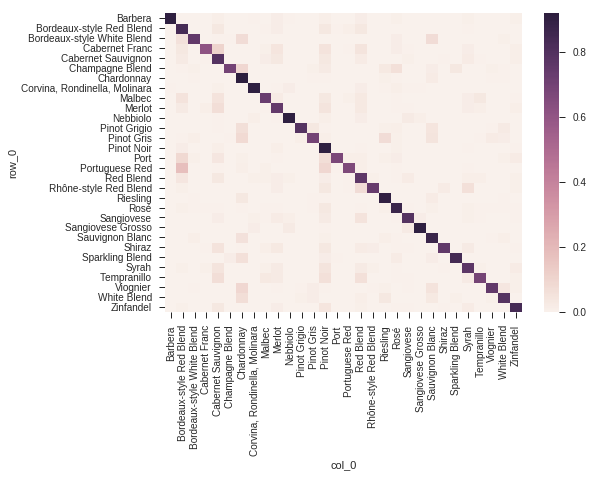

In [92]:
v_lookup = df[['variety_code', 'variety']].drop_duplicates().set_index('variety_code').to_dict()
v_lookup = v_lookup['variety']

y_test_name = np.array([v_lookup[yy] for yy in y_test])
y_pred_name = np.array([v_lookup[yy] for yy in y_pred1])

to_plot = pd.crosstab(y_test_name, y_pred_name, normalize='index')
sns.heatmap(to_plot)

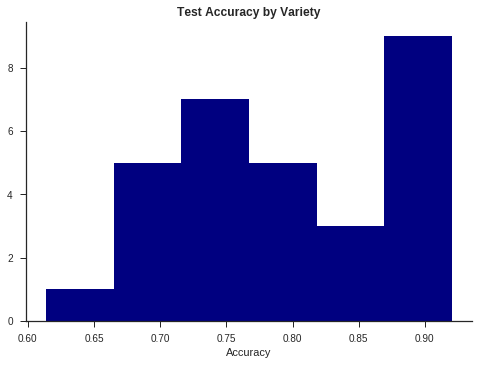

In [93]:
plt.hist(accuracies, bins=6, color='navy')
plt.title('Test Accuracy by Variety', fontweight="bold")
plt.xlabel('Accuracy')
sns.despine()
plt.show()

In [61]:
print(accuracies.max())
print(accuracies.argmax())

0.9204271443334482
6


In [64]:
df[df['variety_code'] == 6].head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery,variety_code
15,15,US,"First made in 2006, this succulent luscious Ch...",Sigrid,95,90.0,Oregon,Willamette Valley,Willamette Valley,Chardonnay,Bergström,6
23,23,US,The apogee of this ambitious winery's white wi...,Giallo Solare,95,60.0,California,Edna Valley,Central Coast,Chardonnay,Center of Effort,6
25,25,New Zealand,"Yields were down in 2015, but intensity is up,...",Maté's Vineyard,94,57.0,Kumeu,NaN,NaN,Chardonnay,Kumeu River,6
31,31,US,"Steely and perfumed, this wine sees only 20% n...",Babushka,90,37.0,California,Russian River Valley,Sonoma,Chardonnay,Zepaltas,6
34,34,US,"The aromas entice with notes of wet stone, hon...",Conner Lee Vineyard,90,42.0,Washington,Columbia Valley (WA),Columbia Valley,Chardonnay,Buty,6


#### Plot Class Output

In [0]:
# plot of classes after being fit for the simple model
# ref: http://www.jacobsilterra.com/2017/05/06/classifying-text-with-keras-visualization/

# get values of last layer for each class and plot them to see which are most similar